# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask

import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.tth import ttHRecoDataset,ttHHardDataset
from memflow.models.transfer_flow_model import TransferFlow
from memflow.models.custom_flows import *
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback


vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

# Data

In [ ]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    N = 1000,
)

print (data_hard)

ValueError: no *.parquet or *.parq matches for path '/nfs/scratch/fynu/fbury/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet'

This error occurred while calling

    ak.metadata(
        '/nfs/scratch/fynu/fbury/MEM_data/ttH/TF_v6/hard/2018/ttH/'...
        None
        row_groups = None
        columns = None
        ignore_metadata = True
        scan_files = False
    )

# Hard dataset

In [6]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        'higgs',
        'tops',
        'bottoms',
        'Ws',
        'Zs',
        'quarks',
        'neutrinos',
    ],
    build = True,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print (hard_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_gen
Saving preprocessing to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_gen
Will overwrite what is in output directory /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_gen/preprocessing
Preprocessing saved in /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_gen/preprocessing
Parton dataset with 178916 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([178916, 1, 4]), mask ([178916, 1])
                   Mask exist    : [100.00%]
                   Mask attn     : [True]
                   Weights       : 178916.00
                   Features      : ['x', 'y', 'z', 't']
                   Selected for batches : False
partons          : data ([178916, 7, 6]), mask ([178916, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.

Before preprocessing


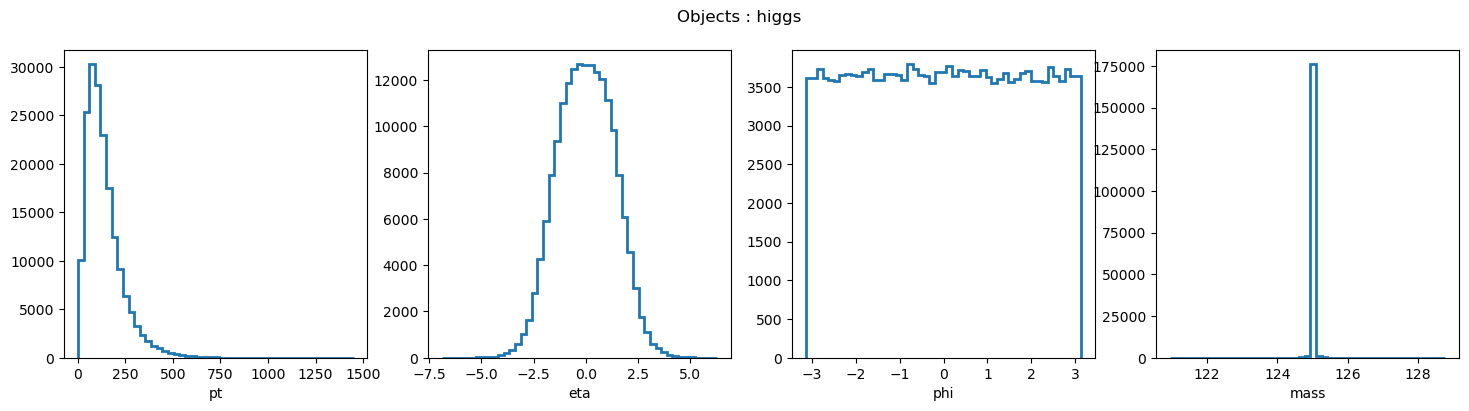

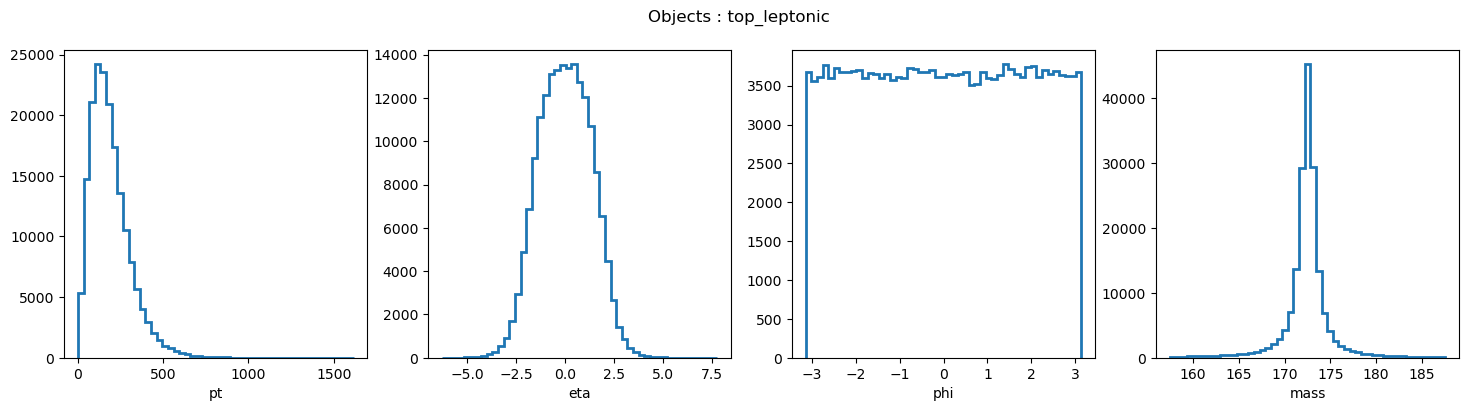

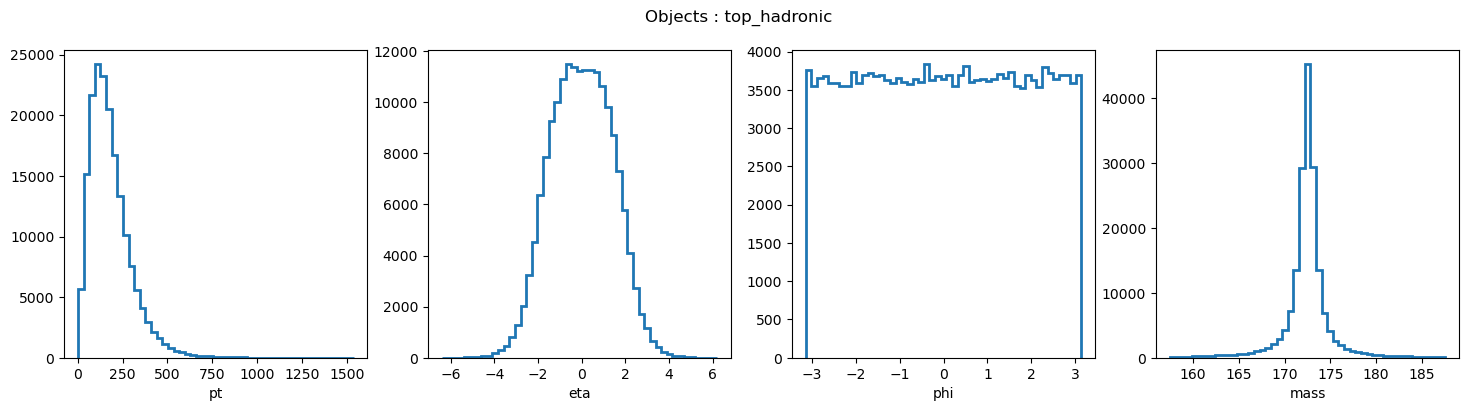

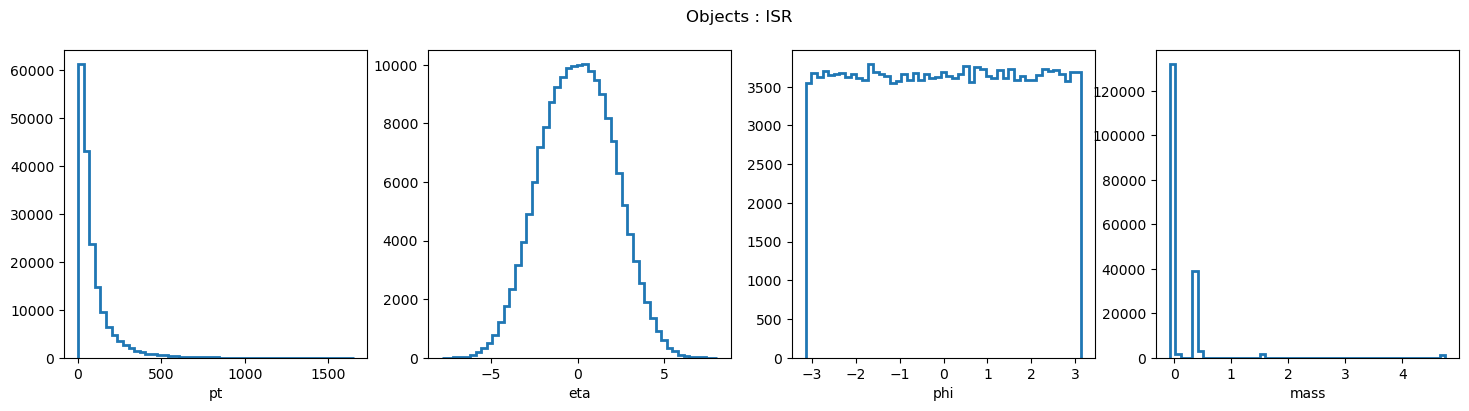

After preprocessing


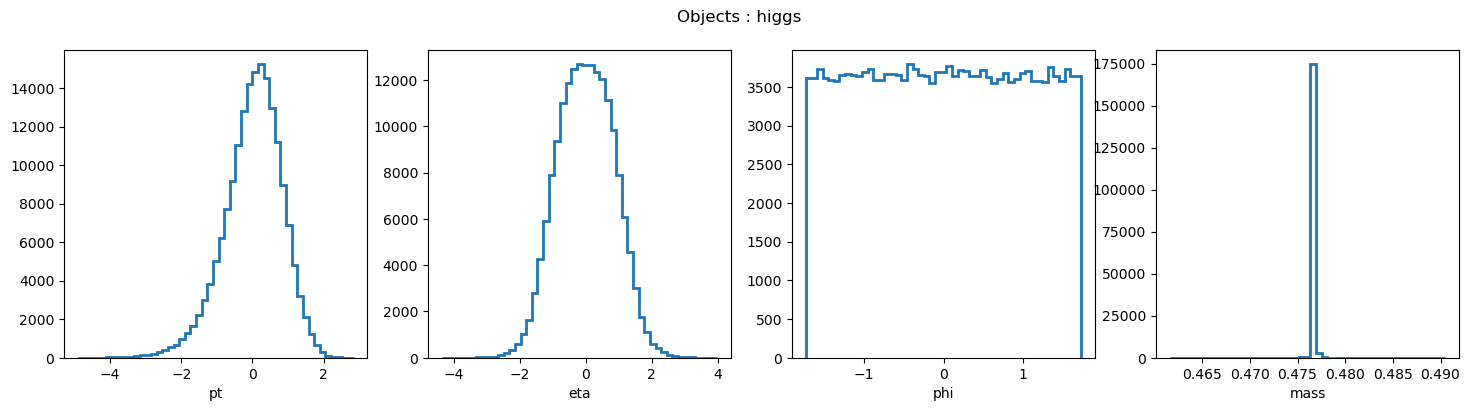

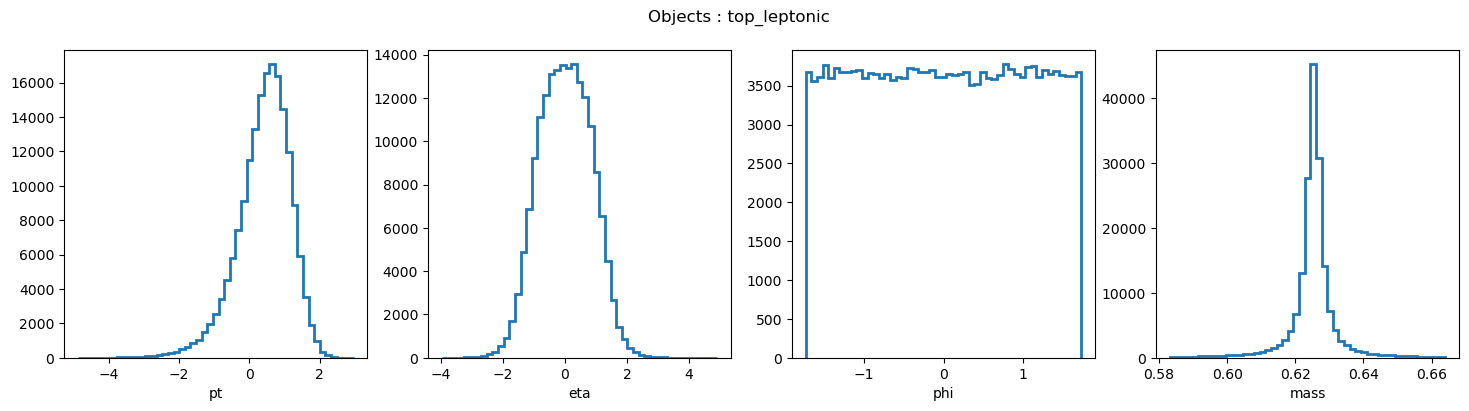

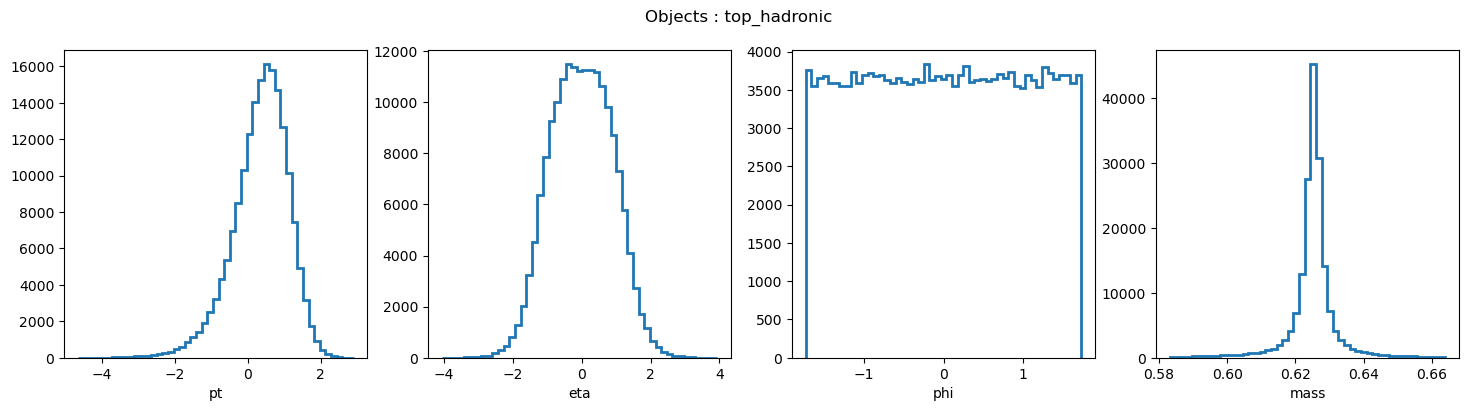

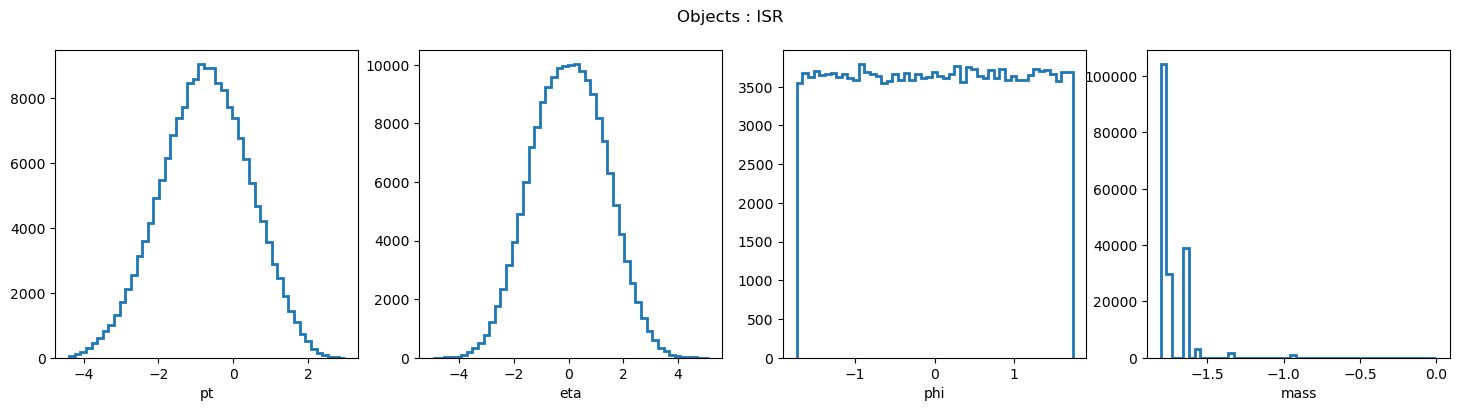

In [7]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

In [8]:
# This is not strictly necessary, but just to make sure loading works as expected
# We will use later a combined dataset (hard+reco) below
hard_loader = DataLoader(
    hard_dataset,
    batch_size = 32,
)
batch = next(iter(hard_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],hard_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

higgs torch.Size([32, 1, 4]) torch.Size([32, 1])
top_leptonic torch.Size([32, 1, 4]) torch.Size([32, 1])
top_hadronic torch.Size([32, 1, 4]) torch.Size([32, 1])
ISR torch.Size([32, 1, 4]) torch.Size([32, 1])


# Reco dataset

In [9]:
reco_dataset = ttHRecoDataset(
    data = data,
    selection = [
        'lepton',
        'met',
        'jets',
    ],
    default_features = {
        'pt' : 0.,
        'eta' : 0.,
        'phi' : 0.,
        'm' : None,
        'btag' : 0.,
        'matched' : None,
        'prov' : None,
    },
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_reco
Saving preprocessing to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_reco
Will overwrite what is in output directory /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_reco/preprocessing
Preprocessing saved in /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/ttH/tth_reco/preprocessing
Reco dataset with 178916 events
Containing the following tensors
boost   : data ([178916, 1, 4]), mask ([178916, 1])
          Mask exist    : [100.00%]
          Mask attn     : [True]
          Weights       : 178916.00
          Features      : ['pt', 'eta', 'phi', 'btag']
          Selected for batches : False
jets    : data ([178916, 16, 7]), mask ([178916, 16])
          Mask exist    : [97.38%, 60.32%, 83.23%, 88.45%, 35.14%, 81.84%, 40.30%, 45.35%, 19.64%, 8.11%, 3.28%, 1.34%, 0.48%, 0.14%, 0.03%, <0.01%]
          Mask attn     : [True, True, True, True, True, True, True, True, True, True, True, True

Before preprocessing


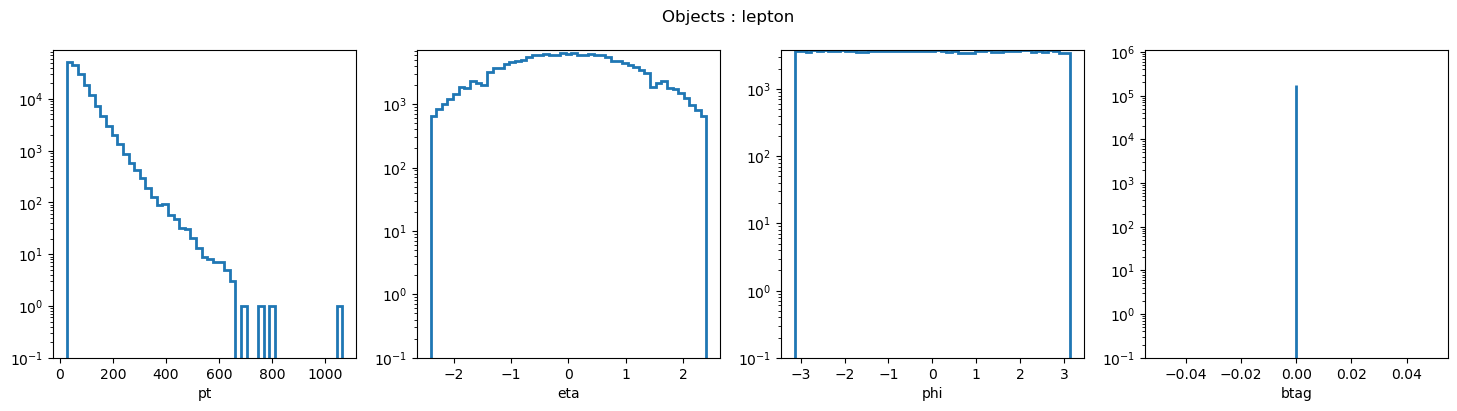

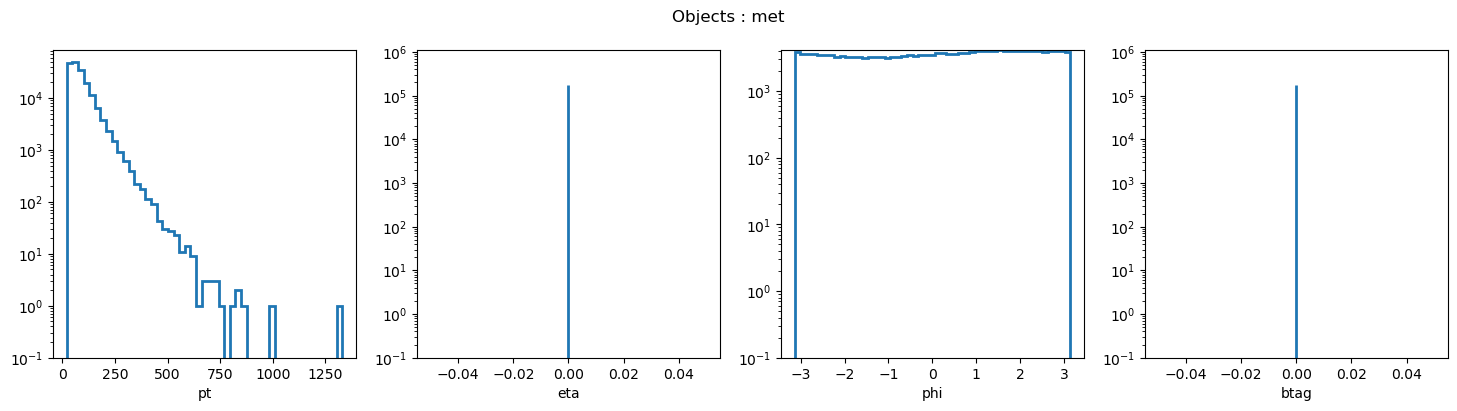

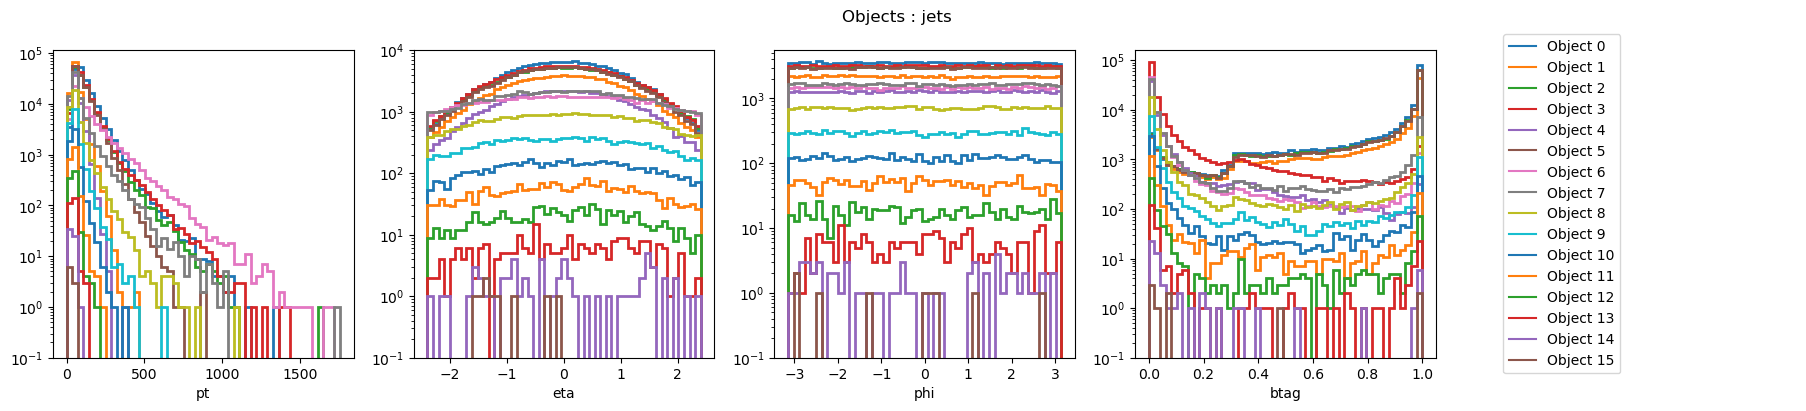

After preprocessing


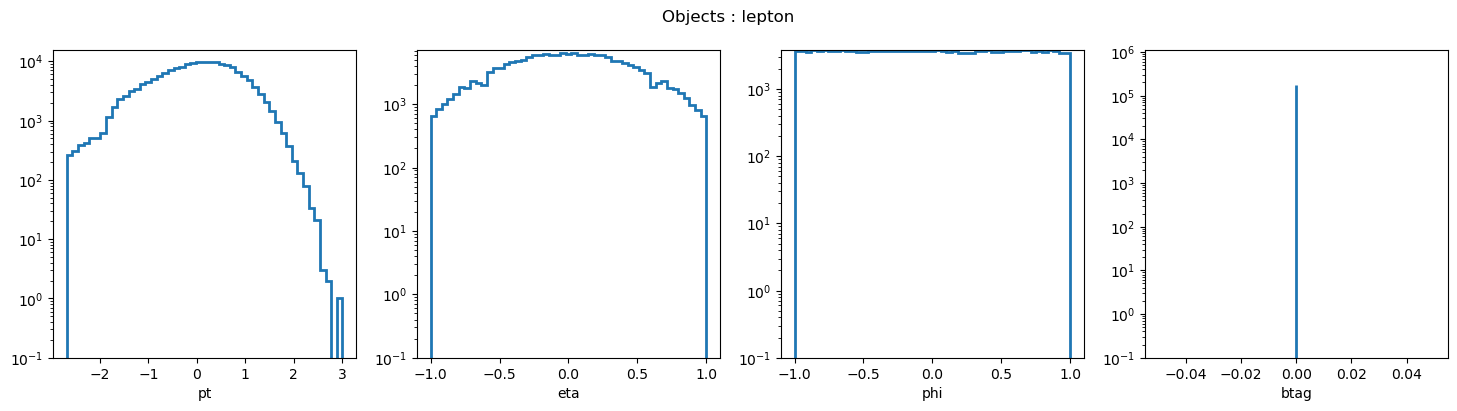

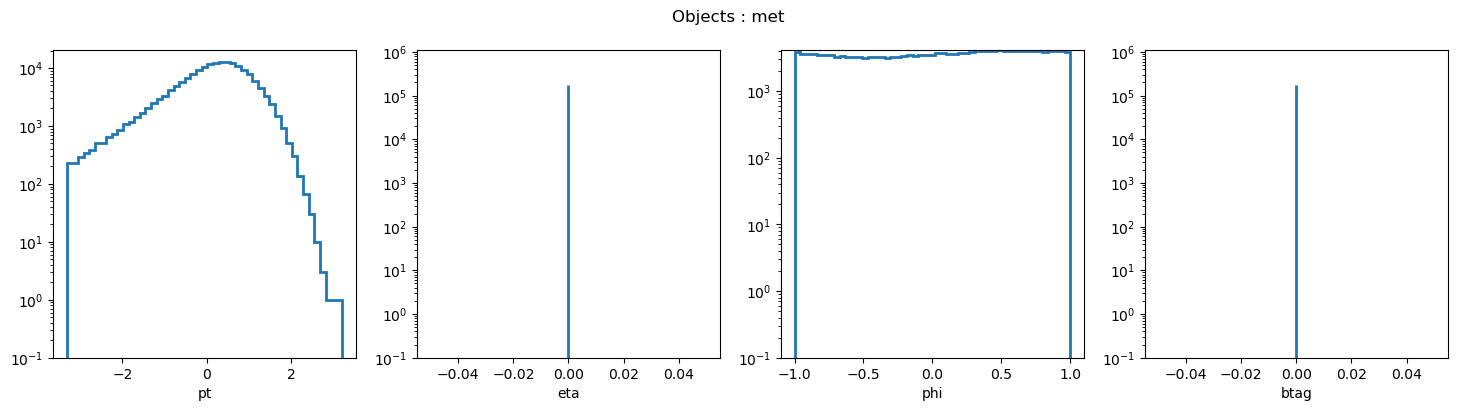

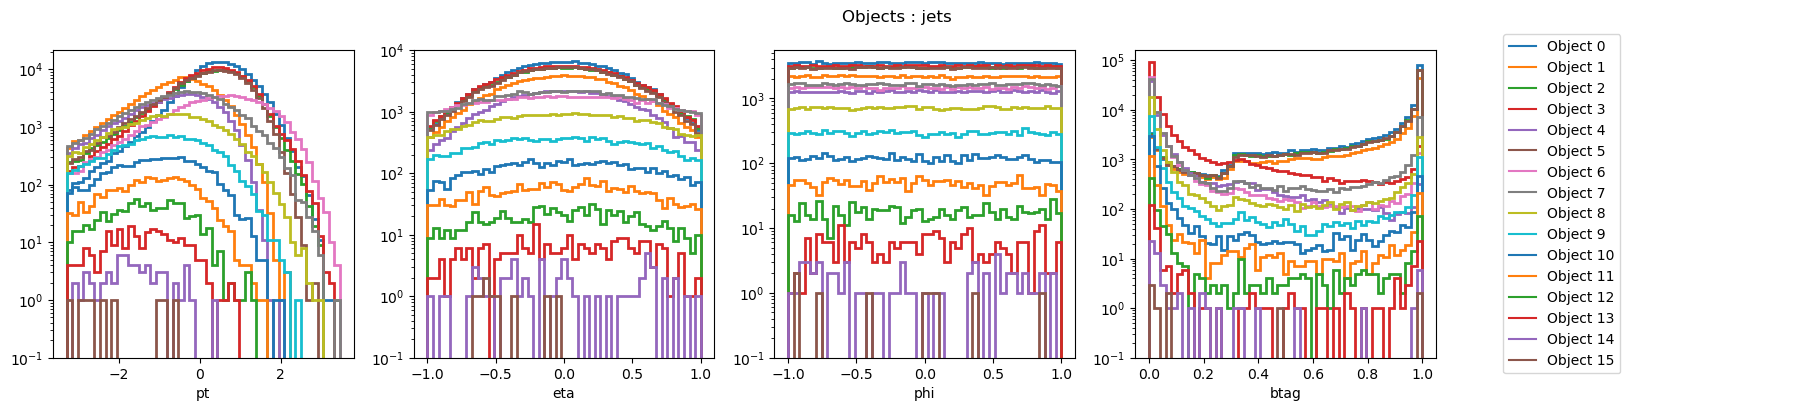

In [10]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [11]:
# Also not needed, just checking 
reco_loader = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(reco_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],reco_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

lepton torch.Size([32, 1, 4]) torch.Size([32, 1])
met torch.Size([32, 1, 4]) torch.Size([32, 1])
jets torch.Size([32, 16, 7]) torch.Size([32, 16])


# Combined dataset

In [12]:
combined_dataset = CombinedDataset(
    hard_dataset = hard_dataset,
    reco_dataset = reco_dataset,
)
print (combined_dataset)

Not intersection branch for either hard or reco datasets, will assume bijection between datasets
Combined dataset (extracting 178916 events of the following) :
Parton dataset with 178916 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([178916, 1, 4]), mask ([178916, 1])
                   Mask exist    : [100.00%]
                   Mask attn     : [True]
                   Weights       : 178916.00
                   Features      : ['x', 'y', 'z', 't']
                   Selected for batches : False
partons          : data ([178916, 7, 6]), mask ([178916, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
                   Mask attn     : [True, True, True, True, True, True, True]
                   Weights       : 178916.00, 178916.00, 178916.00, 178916.00, 178916.00, 178916.00, 178916.00

In [13]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size = 256,
)
batch = next(iter(combined_loader))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],combined_loader.dataset.reco_dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],combined_loader.dataset.hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
lepton torch.Size([256, 1, 4]) torch.Size([256, 1])
met torch.Size([256, 1, 4]) torch.Size([256, 1])
jets torch.Size([256, 16, 7]) torch.Size([256, 16])
Hard
higgs torch.Size([256, 1, 4]) torch.Size([256, 1])
top_leptonic torch.Size([256, 1, 4]) torch.Size([256, 1])
top_hadronic torch.Size([256, 1, 4]) torch.Size([256, 1])
ISR torch.Size([256, 1, 4]) torch.Size([256, 1])


In [14]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

combined_dataset_train = torch.utils.data.Subset(combined_dataset,train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

combined_loader_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
combined_loader_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(combined_loader_train)} / Validation {len(combined_loader_valid)}')

Dataset : training 143132 / validation 35784
Batching 140 / Validation 4


In [15]:
# Find some indices in the validation set with max number of jets
# To use in the sampling to see a maximum number of jets
count = ak.count(data['jets'].pt,axis=1).to_numpy()
mask_max = count == ak.max(count)
mask_valid = np.full(len(count),fill_value=False)
mask_valid[valid_indices] = True
idx_max = np.where(
    np.logical_and(mask_max,mask_valid)
)[0]
for i in idx_max:
    prov = data['jets'].prov[i]
    unique, counts = np.unique(prov, return_counts=True)
    print ('idx',i,', '.join([f'prov {u:.0f} x {c:.0f}' for u,c in zip(unique, counts)]))

idx 143187 prov -1 x 3, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 4 x 1, prov 5 x 2
idx 143355 prov -1 x 6, prov 1 x 1, prov 2 x 1, prov 3 x 1, prov 5 x 1
idx 143569 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 4 x 1, prov 5 x 2
idx 143679 prov -1 x 5, prov 1 x 2, prov 2 x 1, prov 4 x 1, prov 5 x 1
idx 144119 prov -1 x 6, prov 1 x 2, prov 3 x 1, prov 5 x 1
idx 144732 prov -1 x 7, prov 1 x 2, prov 2 x 1
idx 144962 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 144992 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 145307 prov -1 x 5, prov 1 x 2, prov 2 x 1, prov 5 x 2
idx 145492 prov -1 x 5, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 4 x 1
idx 145693 prov -1 x 6, prov 1 x 1, prov 2 x 1, prov 4 x 1, prov 5 x 1
idx 146034 prov -1 x 6, prov 1 x 2, prov 2 x 1, prov 3 x 1
idx 146297 prov -1 x 5, prov 1 x 1, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 146355 prov -1 x 7, prov 1 x 2, prov 5 x 1
idx 146503 prov -1 x 5, prov 1 x 2, prov 3 x 1, prov 4 x 1, prov 5 x 1
idx 146

# Transfer flow

In [16]:
# Transfer flow #
model = TransferFlow(
    # General args #
    dropout = 0.,
    # Embedding arguments #
    embed_dims = [32,64],
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = combined_dataset.hard_dataset.number_particles_per_type,
    hard_particle_type_names = combined_dataset.hard_dataset.selection,
    hard_input_features_per_type = combined_dataset.hard_dataset.input_features,
    n_reco_particles_per_type = combined_dataset.reco_dataset.number_particles_per_type,
    reco_particle_type_names = combined_dataset.reco_dataset.selection,
    reco_input_features_per_type = combined_dataset.reco_dataset.input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        ['pt','eta','phi'], # leptons
        ['pt','phi'],           # met
        ['pt','eta','phi'], # jets
    ],
    hard_mask_attn = None,
    reco_mask_attn = combined_dataset.reco_dataset.attention_mask,
    # Transformer arguments #
    onehot_encoding = False, # add onehot encoded position vector to particles
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 128, 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 2,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

# Just check the model before training #
batch = next(iter(combined_loader_train))

log_probs, mask, weights = model(batch)
mask = mask > 0
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['hard']['data'],batch['hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)

No hard attention mask provided, will use the exist mask for the attention


/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim=-1)


log_probs tensor([[2.2821, 2.3901, 3.0148,  ..., 2.3346, 2.3394, 2.3439],
        [2.9144, 1.9224, 2.4555,  ..., 2.7150, 2.7178, 2.7202],
        [1.8279, 1.6139, 2.8399,  ..., 2.7313, 2.7348, 2.7385],
        ...,
        [3.2305, 4.2286, 1.9536,  ..., 2.3154, 2.3203, 2.3249],
        [3.3307, 1.8115, 2.0529,  ..., 2.6903, 2.6910, 2.6914],
        [2.5715, 2.9797, 2.5394,  ..., 2.7826, 2.7843, 2.7856]],
       grad_fn=<NegBackward0>) torch.Size([1024, 18])
mask tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]]) torch.Size([1024, 18])
weights tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
       

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tot log probs tensor(3.0122, grad_fn=<MeanBackward0>)
samples
	 torch.Size([100, 1024, 1, 3])
	 torch.Size([100, 1024, 1, 2])
	 torch.Size([100, 1024, 16, 3])
TransferFlow(
  (hard_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
   

In [17]:
# Callbacks to make plots within comet

bias = BiasCallback(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    frequency = 10,                                 # plotting frequency (epochs)
    bins = 51,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 5000,                              # Batch size to evaluate the dataset (internally makes a loaded)
    #N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                                 # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)
# figs = bias.make_bias_plots(model.cuda(),show=True) # show is to plot standalone 
# of course now they are bad, need to train first

In [18]:
idx_to_monitor = [0,1,2]
sampling = SamplingCallback(
    dataset = combined_dataset_valid,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [0,1,2,3,4],               # idx of events in dataset to make plots with
    N_sample = 1000000,                         # number of samples to draw
    frequency = 10,                             # plotting frequency (epochs)
    bins = 51,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)
# figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

In [ ]:
##### Parameters #####
epochs = 200
steps_per_epoch_train = math.ceil(len(combined_dataset_train)/combined_loader_train.batch_size)

print (f'Training   : Batch size = {combined_loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=0, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
    bias,
]

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-ttH',
    experiment_name = 'combined',
    offline = False,
) 
logger.log_graph(model)
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train/100,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = combined_loader_train,
    val_dataloaders = combined_loader_valid,
)

Training   : Batch size = 1024 => 140 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-tth/c4fd23478341415c857f1c301884baab

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` call

Sanity Checking: |                                                                                            …

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(ncols=N,nrows=3,figsize=(5*N,12))


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

infs at coordinates [tensor([779], device='cuda:0'), tensor([2], device='cuda:0')]


Validation: |                                                                                                 …

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [ ]:
figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

In [ ]:
figs = bias.make_bias_plots(model.cuda(),show=True) # show is to plot standalone 